# Lab 2: Hidden Markov Models

### Dependencies

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from lab2_tools import *
from lab2_proto import *

## Data & Model Set

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [3]:
data[0]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16),
 'lmfcc': array([[  64.7657709 ,  -65.84854216,   96.90766069, ...,  -19.82632821,
           11.63249931,  159.50790488],
        [  57.72402791,  -79.93732698,  105.80893583, ...,  -11.84501965,
          109.29701349,  138.79176124],
        [  62.16944867, -121.81014369,   61.89899215, ...,   13.28252915,
         -127.7140298 , -128.75563442],
        ...,
        [ 190.29491187,   97.34488369,  175.61357289, ...,  -62.63035172,
          138.96640354,   82.95734165],
        [ 201.37123403,   80.09496653,   50.98133557, ...,  219.16711476,
           94.41131525, -100.10312668],
        [ 194.17067167,   70.85205455,   40.456538  , ...,   -3.81053312,
          143.83615904,  -42.56212766]])}

In [4]:
for x in data[0]: 
    print(x, end = '\t')  
    if x in ['digit', 'gender', 'filename', 'samplingrate', 'speaker', 'repetition']:
        print(data[0].get(x))
    else:
        print(data[0].get(x).shape)

filename	/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav
samplingrate	20000
gender	man
speaker	bm
digit	o
repetition	a
samples	(16640,)
lmfcc	(82, 13)


### Phonetic Models

In [5]:
phoneHMMs_onespkr = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

In [6]:
print(list(sorted(phoneHMMs_onespkr.keys())),end = '\t')

['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']	

In [7]:
phoneHMMs_onespkr['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

In [8]:
for x in phoneHMMs_onespkr.keys(): 
    print(x, end = '\t')
print('\n', len(phoneHMMs_onespkr))

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	
 21


In [9]:
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
for x in phoneHMMs_all.keys(): print(x, end = '\t')

f	k	n	r	s	t	v	w	z	ah	ao	ay	eh	ey	ih	iy	ow	sp	th	uw	sil	

In [10]:
print(phoneHMMs_all['ah'].keys())

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])


### Pronunciation dictionary and utterance models

In [11]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

In [12]:
isolated = {}

In [13]:
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [14]:
isolated

{'o': ['sil', 'ow', 'sil'],
 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'],
 '1': ['sil', 'w', 'ah', 'n', 'sil'],
 '2': ['sil', 't', 'uw', 'sil'],
 '3': ['sil', 'th', 'r', 'iy', 'sil'],
 '4': ['sil', 'f', 'ao', 'r', 'sil'],
 '5': ['sil', 'f', 'ay', 'v', 'sil'],
 '6': ['sil', 's', 'ih', 'k', 's', 'sil'],
 '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'],
 '8': ['sil', 'ey', 't', 'sil'],
 '9': ['sil', 'n', 'ay', 'n', 'sil']}

## Concatenating HMMs

In [15]:
def concatTwoHMMs(hmm1, hmm2):
    """ Concatenates 2 HMM models

    Args:
       hmm1, hmm2: two dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be different for each)

    Output
       dictionary with the same keys as the input but concatenated models:
          startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models
   
    Example:
       twoHMMs = concatHMMs(phoneHMMs['sil'], phoneHMMs['ow'])

    See also: the concatenating_hmms.pdf document in the lab package
    """
    concatedHMM = {}
    #M is the number of emitting states in each HMM model (could be different for each)
    #K is the sum of the number of emitting states from the input models
    
    M1 = hmm1['means'].shape[0]
    M2 = hmm2['means'].shape[0]
    K = M1 + M2
    
    concatedHMM['name'] = hmm1['name'] + hmm2['name']
    concatedHMM['startprob'] = np.zeros((K + 1, 1))
    concatedHMM['transmat'] = np.zeros((K + 1, K + 1))
    concatedHMM['means'] = np.vstack((hmm1['means'],hmm2['means']))
    concatedHMM['covars'] = np.vstack((hmm1['covars'],hmm2['covars']))
        
    
    start1 = hmm1['startprob'].reshape(-1,1)
    start2 = hmm2['startprob'].reshape(-1,1)
    
    concatedHMM['startprob'][:hmm1['startprob'].shape[0]-1,:] = start1[:-1,:]
    concatedHMM['startprob'][hmm1['startprob'].shape[0]-1:,:] = np.dot(start1[-1,0],start2)
    trans = concatedHMM['transmat']
    trans1 = hmm1['transmat']
    trans2 = hmm2['transmat']

    trans[:trans1.shape[0]-1,:trans1.shape[1]-1] = trans1[:-1,:-1]
    temp = trans1[:-1,-1].reshape(-1,1)
    trans[:trans1.shape[0]-1,trans1.shape[1]-1:] = \
                            np.dot(temp,start2.T)
    trans[trans1.shape[0]-1:,trans1.shape[1]-1:] = trans2
    concatedHMM['transmat'] = trans    
    
    return concatedHMM

In [16]:
# this is already implemented, but based on concat2HMMs() above
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [17]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

In [19]:
print(list(example.keys()), end='\t')

['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma']	

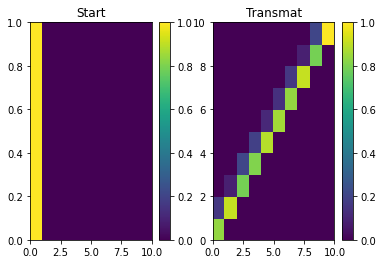

In [21]:
isolated = {}
wordHMMs = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']
    wordHMMs[digit] = concatHMMs(phoneHMMs_onespkr, isolated[digit])
_ = plt.subplot(122).set_title("Transmat")
_ = plt.pcolormesh(wordHMMs['o']['transmat'].T)
_ = plt.colorbar()
_ = plt.subplot(121).set_title("Start")
_ = plt.pcolormesh(wordHMMs['o']['startprob'].T)
_ = plt.colorbar()

## HMM Likelihood and Recognition

### Gaussian emission probabilities

Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on a test utterance of your choice. What can you say about the figure? Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence.

In [26]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])  

In [27]:
np.allclose(obsloglik, example['obsloglik'])

True

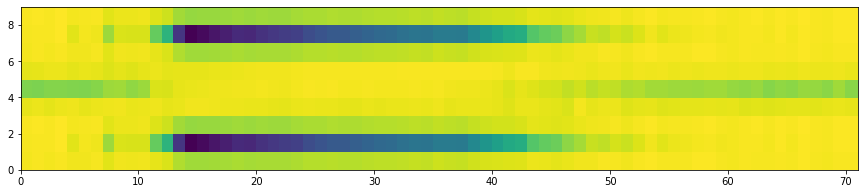

In [28]:
plt.rcParams['figure.figsize'] = [15, 3]
plt.subplot(121).set_title("Observation Likelihood")
plt.pcolormesh(obsloglik.T)

In [25]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    alpha = np.zeros(log_emlik.shape)
    alpha[0][:] = log_startprob.T + log_emlik[0]

    for n in range(1,len(alpha)):
        for i in range(alpha.shape[1]):
            alpha[n, i] = logsumexp(alpha[n - 1] + log_transmat[:,i]) + log_emlik[n,i]
    return alpha